In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# **DEFINE FUNCTION**

## **Function of Attribute Data Distribution**

In [2]:
def plot_distribution(df, plots_per_row=4, figsize=(12, 5), color='coral'):
    # Calculate the number of columns and rows
    num_columns = len(df.columns)
    num_rows = (num_columns + plots_per_row - 1) // plots_per_row

    # Create a figure
    fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(12*plots_per_row,5*num_rows))

    for i, column in enumerate(df.columns):
        # Calculate the row and column indices
        row, col = divmod(i, plots_per_row)
        # Plot the distribution
        sns.histplot(df[column], kde=True, ax=axes[row, col], color=color)
        # Set title
        axes[row, col].set_title(f'Distribution of {column}')

    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)

    # Display the plot
    plt.tight_layout()
    plt.show()

## **Removing Outliers Using Interquartile Range (IQR)**

In [3]:
def remove_outliers_iqr(df):

    for col in df.columns:

        # Check if the column is numeric
        if np.issubdtype(df[col].dtype, np.number):

            # Calculate the Interquartile Range (IQR)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            # Determine the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Remove outliers
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Reset index to ensure continuous index after removal
    df.reset_index(drop=True, inplace=True)

    return df

## **Column-Wise Data Normalization**

In [4]:
def preprocess_data(df, scaler):

    # Create a copy without the 'Churn'
    df_processed = df.drop('Churn', axis=1).copy()

    # One-hot encoding for 'Area code'
    df_processed = pd.get_dummies(df_processed, columns=['Area code'])

    # Map 'International plan' and 'Voice mail plan' to numerical values
    df_processed['International plan'] = df_processed['International plan'].map({'No': 0, 'Yes': 1})
    df_processed['Voice mail plan'] = df_processed['Voice mail plan'].map({'No': 0, 'Yes': 1})

    # Min-max scaling for 'Number vmail messages'
    minmax_scaler = MinMaxScaler()
    df_processed['Number vmail messages'] = minmax_scaler.fit_transform(df_processed[['Number vmail messages']])

    # Normalize remaining columns according to the scaler
    columns_to_normalize = ['Account length', 'Total day minutes', 'Total day calls',
                            'Total eve minutes', 'Total eve calls', 'Total night minutes',
                            'Total night calls', 'Total intl minutes', 'Total intl calls',
                            'Customer service calls']

    if scaler == 'minmax':
        minmax_scaler = MinMaxScaler()
        df_processed[columns_to_normalize] = minmax_scaler.fit_transform(df_processed[columns_to_normalize])
    elif scaler == 'standard':
        standard_scaler = StandardScaler()
        df_processed[columns_to_normalize] = standard_scaler.fit_transform(df_processed[columns_to_normalize])

    return df_processed

## **GridSearch with Cross-Validation for Hyperparameter Tuning**

In [5]:
def perform_grid_search(X_train, y_train, model, param_grid):

    # Initialize GridSearchCV with the given model and parameter grid
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    return grid_search

## **Remove Columns from DataFrame**

In [6]:
def remove_col(df, eliminate_columns=['Total day charge',
                                     'Total eve charge',
                                     'Total night charge',
                                     'Total intl charge',
                                     'State']):

    df = df.drop(columns=eliminate_columns)
    return df

# **READ DATA FOR TRAINING PHASE**

In [18]:
df = pd.read_csv('./churn-bigml-80.csv')
df.tail()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
2665,TN,74,415,No,Yes,25,234.4,113,39.85,265.9,82,22.60,241.4,77,10.86,13.7,4,3.70,0,False


In [19]:
df['Churn'].value_counts()

Churn
False    2278
True      388
Name: count, dtype: int64

# **EDA AND PREPROCESS DATA**

## **Exploratory Data Analysis (EDA)**

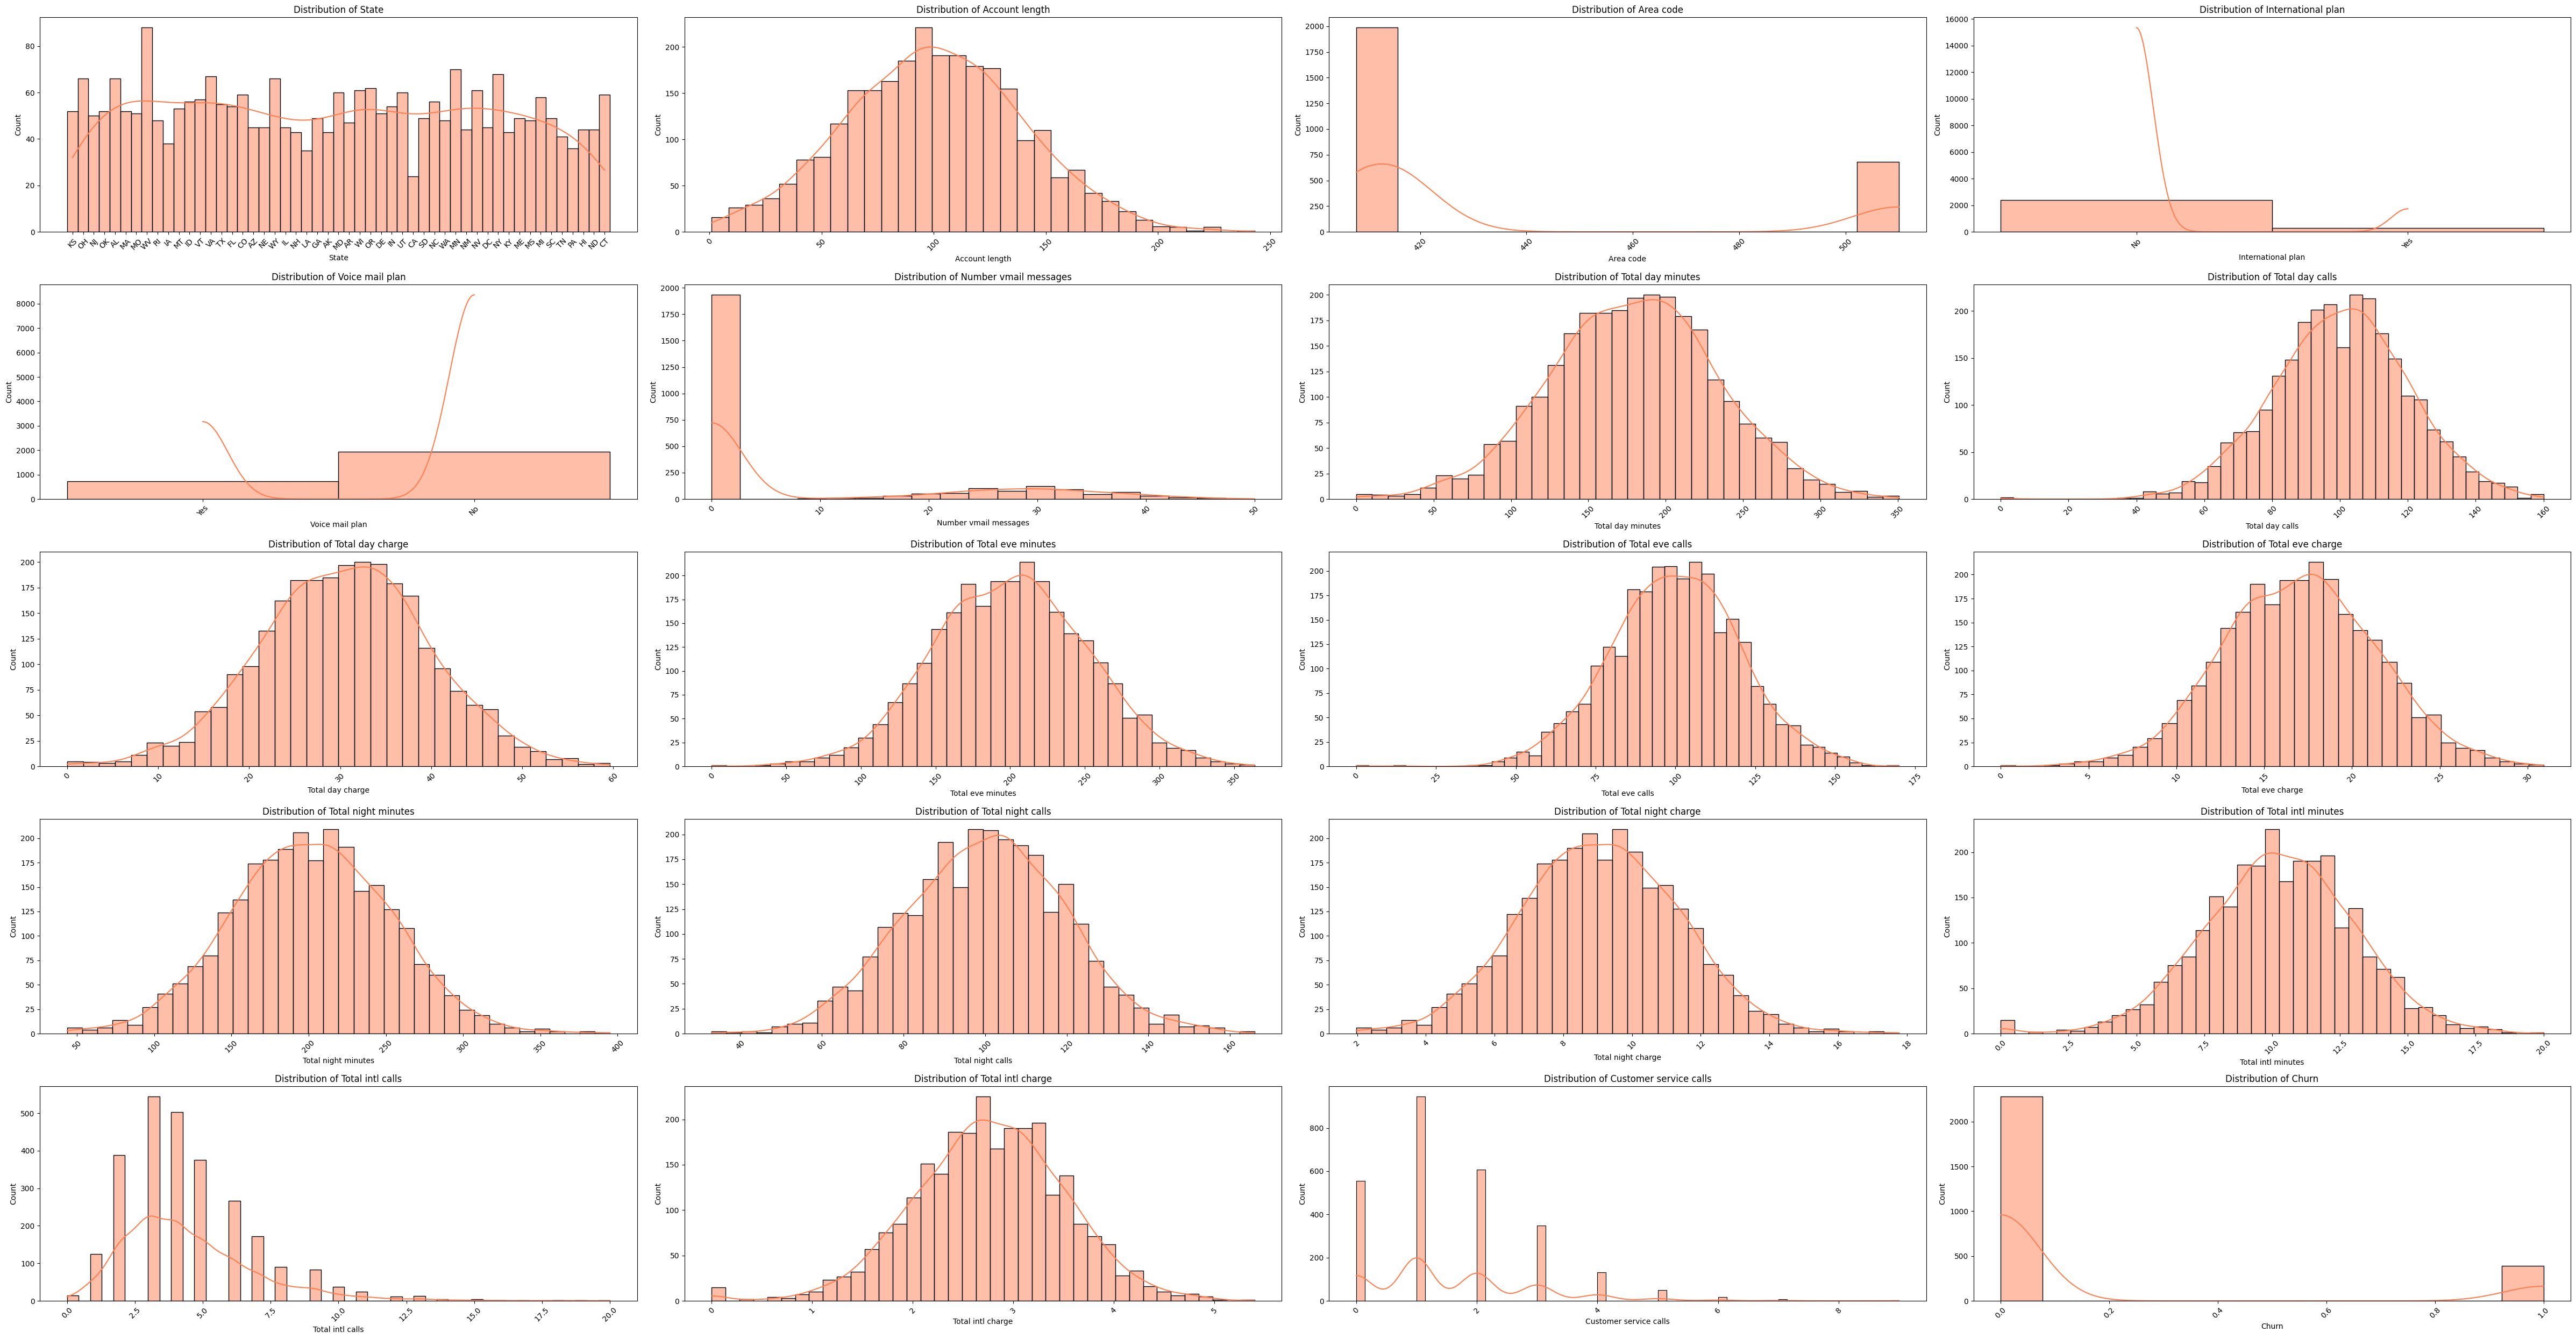

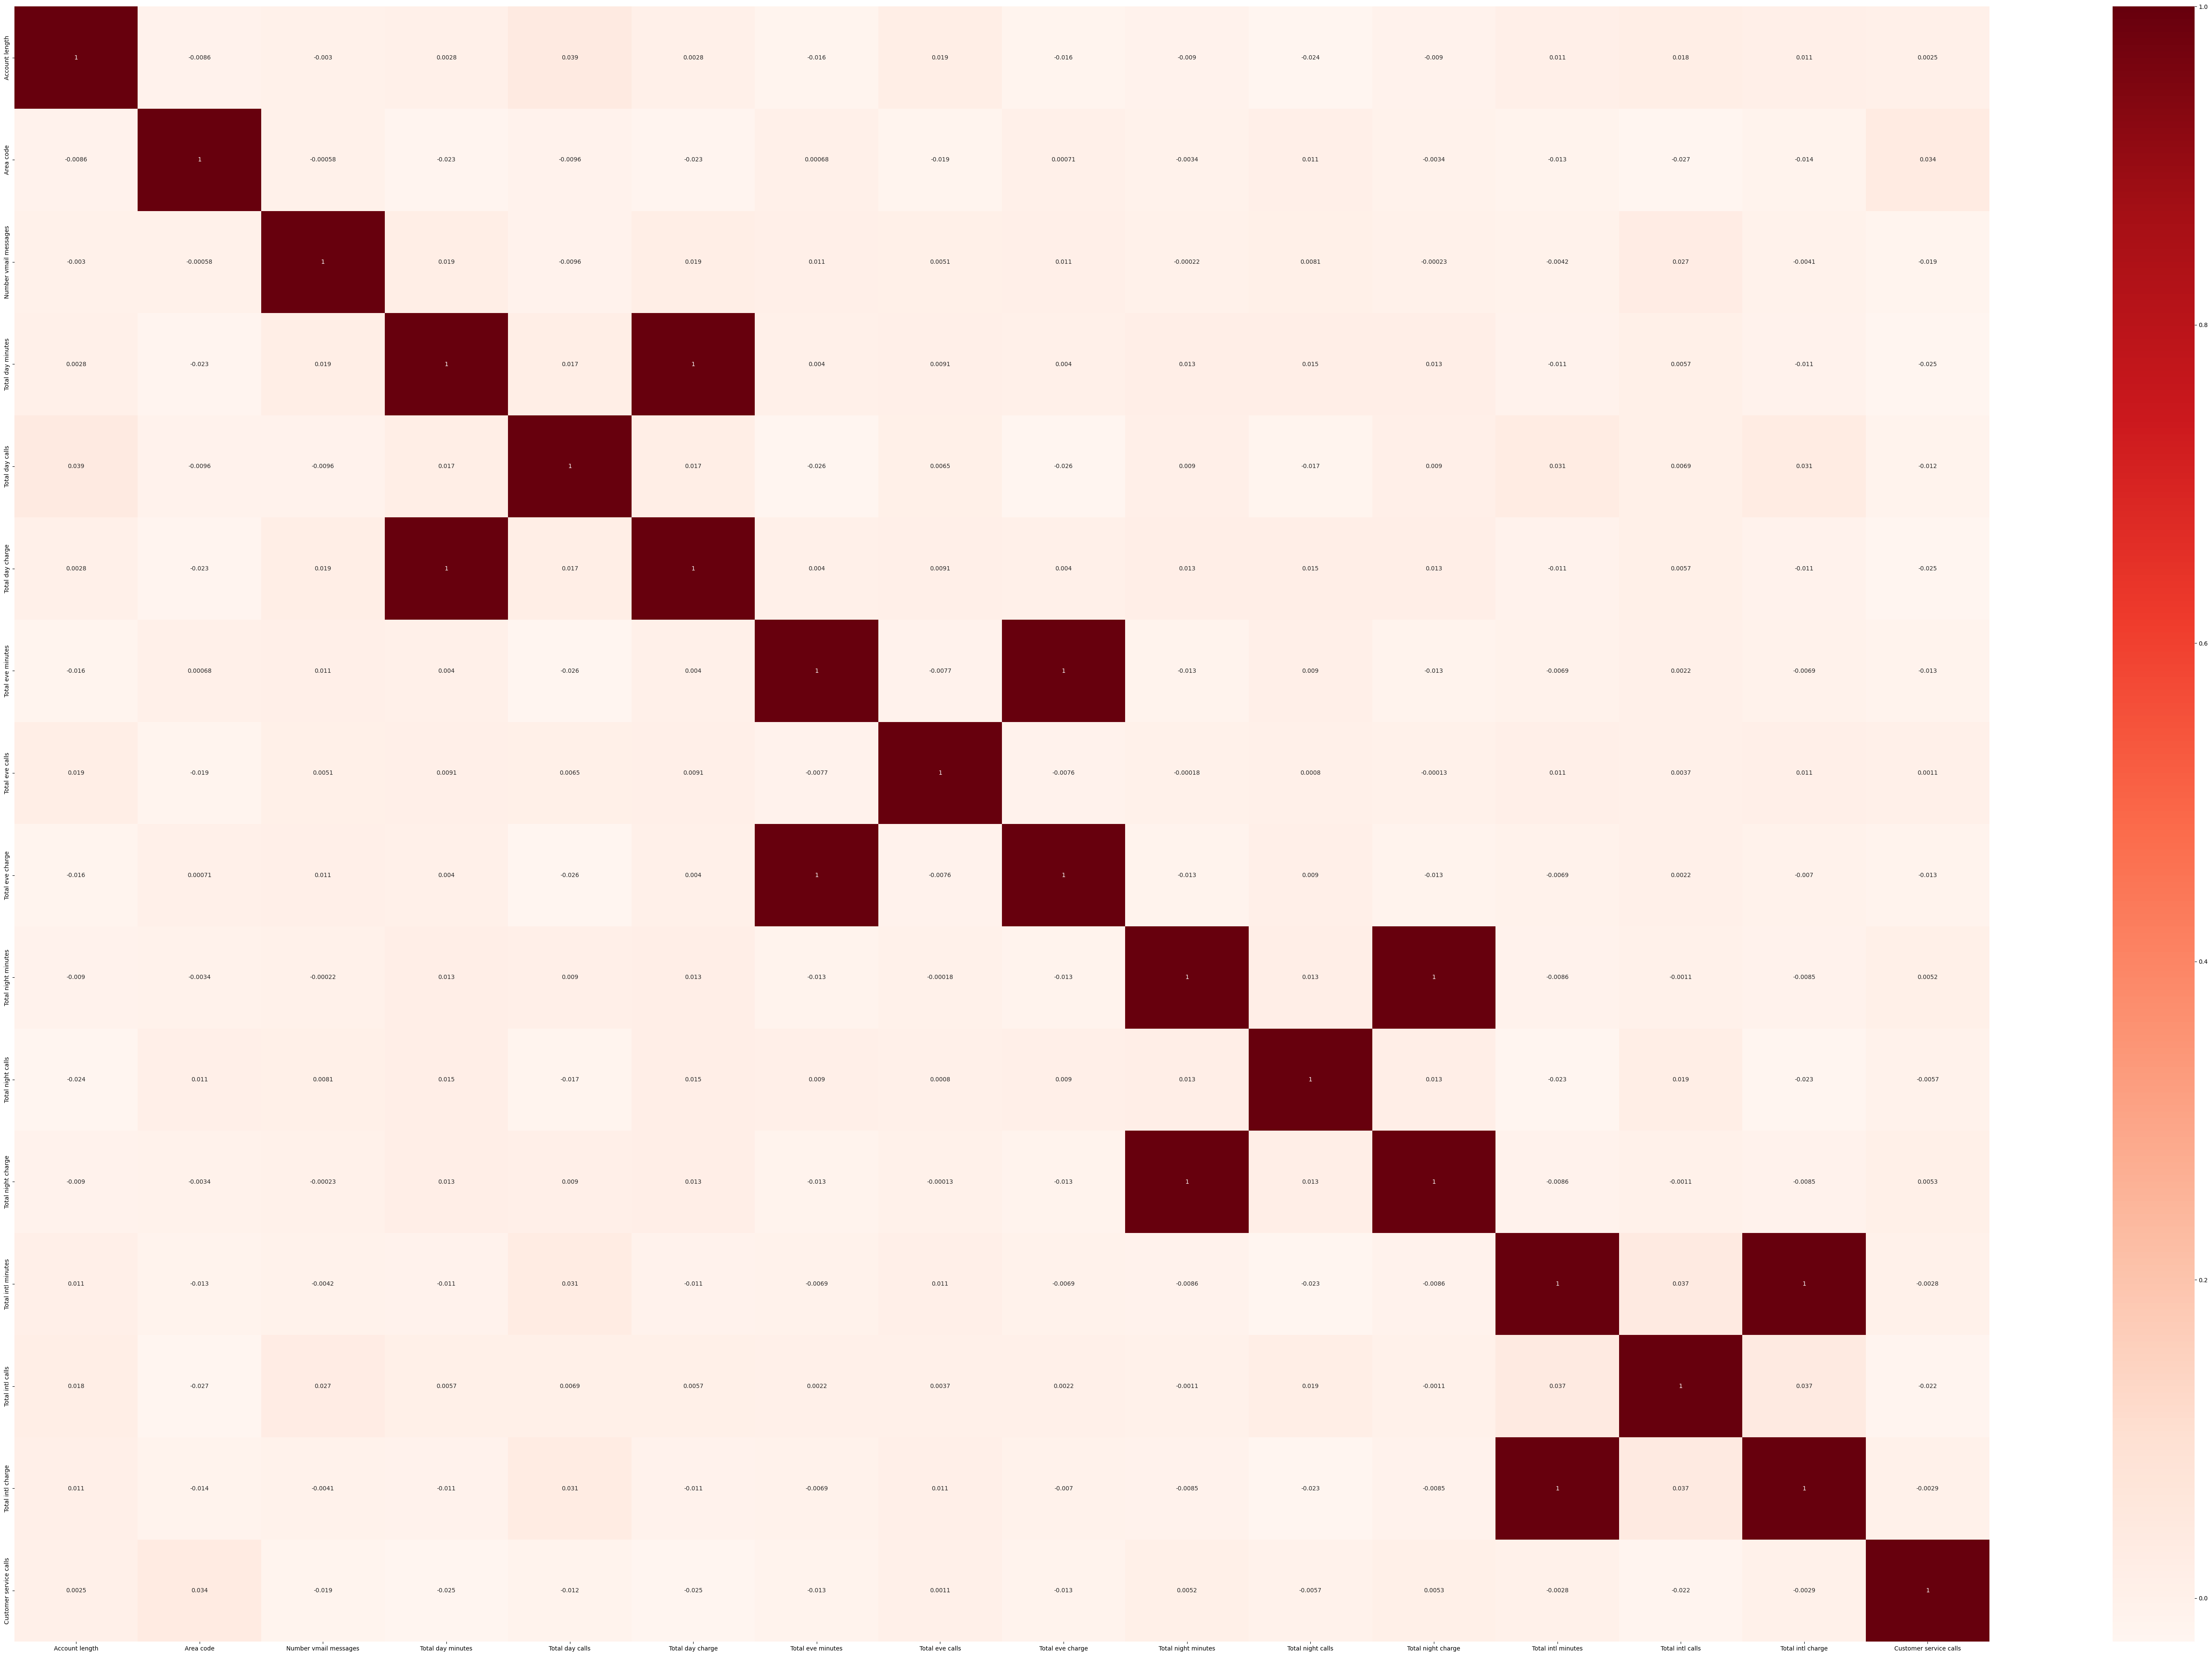

Pairs of attributes with correlation > 0.95:
            Attribute 1         Attribute 2  Correlation
4     Total day minutes    Total day charge     1.000000
9     Total eve minutes    Total eve charge     1.000000
14  Total night minutes  Total night charge     0.999999
19   Total intl minutes   Total intl charge     0.999993


In [20]:
# Plot the distribution of each column in the DataFrame
plot_distribution(df)

numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(75, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds')
plt.show()

# Find pairs of attributes with correlation greater than 0.95
high_correlation = correlation_matrix[abs(correlation_matrix) > 0.95].stack().reset_index()
high_correlation = high_correlation[high_correlation['level_0'] != high_correlation['level_1']]
high_correlation.columns = ['Attribute 1', 'Attribute 2', 'Correlation']
high_correlation = high_correlation.drop_duplicates(subset=['Correlation'])

# Print pairs of attributes with correlation greater than 0.95
print("Pairs of attributes with correlation > 0.95:")
print(high_correlation)

## **Remove Redundant Attributes Based on Correlation**

In [21]:
eliminate_columns = high_correlation['Attribute 2'].tolist()
eliminate_columns.append('State')

df = remove_col(df, eliminate_columns)

# **TRAINING PHASE**

## **Tune Model Hyperparameter with Grid Search and Scalers**

In [22]:
# Preprocess the data using MinMaxScaler and StandardScaler
df_mm = preprocess_data(df, 'minmax')
df_std = preprocess_data(df, 'standard')

# Split the data into train and validation sets (85% train, 15% validation)
X_train_mm, X_val_mm, y_train_mm, y_val_mm = train_test_split(df_mm, df['Churn'], test_size=0.15, random_state=42)
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(df_std, df['Churn'], test_size=0.15, random_state=42)

# Grid search for Logistic Regression with different scalers
param_grid_logreg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
logreg_grid_mm = perform_grid_search(X_train_mm, y_train_mm, LogisticRegression(max_iter=1000), param_grid_logreg)
logreg_grid_std = perform_grid_search(X_train_std, y_train_std, LogisticRegression(max_iter=1000), param_grid_logreg)

# Grid search for Decision Tree with different scalers
param_grid_dt = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 7, 10]}
dt_grid_mm = perform_grid_search(X_train_mm, y_train_mm, DecisionTreeClassifier(), param_grid_dt)
dt_grid_std = perform_grid_search(X_train_std, y_train_std, DecisionTreeClassifier(), param_grid_dt)

# Grid search for Random Forest with different scalers
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10]}
rf_grid_mm = perform_grid_search(X_train_mm, y_train_mm, RandomForestClassifier(), param_grid_rf)
rf_grid_std = perform_grid_search(X_train_std, y_train_std, RandomForestClassifier(), param_grid_rf)

# Print the best parameters for each model and scaler combination
print("Logistic Regression - MinMaxScaler - Best params:", logreg_grid_mm.best_params_)
print("Logistic Regression - StandardScaler - Best params:", logreg_grid_std.best_params_)
print("Decision Tree - MinMaxScaler - Best params:", dt_grid_mm.best_params_)
print("Decision Tree - StandardScaler - Best params:", dt_grid_std.best_params_)
print("Random Forest - MinMaxScaler - Best params:", rf_grid_mm.best_params_)
print("Random Forest - StandardScaler - Best params:", rf_grid_std.best_params_)

Logistic Regression - MinMaxScaler - Best params: {'C': 1}
Logistic Regression - StandardScaler - Best params: {'C': 0.1}
Decision Tree - MinMaxScaler - Best params: {'max_depth': 7, 'min_samples_split': 10}
Decision Tree - StandardScaler - Best params: {'max_depth': 7, 'min_samples_split': 10}
Random Forest - MinMaxScaler - Best params: {'max_depth': 10, 'n_estimators': 200}
Random Forest - StandardScaler - Best params: {'max_depth': 10, 'n_estimators': 100}


## **Model Evaluation**

In [24]:
# Initialize a dictionary to store evaluation scores
evaluation_scores = {}

# Evaluate Logistic Regression model with MinMaxScaler
y_pred_logreg_mm = logreg_grid_mm.best_estimator_.predict(X_val_mm)
accuracy_logreg_mm = accuracy_score(y_val_mm, y_pred_logreg_mm)
f1_logreg_mm = f1_score(y_val_mm, y_pred_logreg_mm)
evaluation_scores[('Logistic Regression', 'MinMaxScaler')] = {'Accuracy': accuracy_logreg_mm, 'F1': f1_logreg_mm}

# Evaluate Logistic Regression model with StandardScaler
y_pred_logreg_std = logreg_grid_std.best_estimator_.predict(X_val_std)
accuracy_logreg_std = accuracy_score(y_val_std, y_pred_logreg_std)
f1_logreg_std = f1_score(y_val_std, y_pred_logreg_std)
evaluation_scores[('Logistic Regression', 'StandardScaler')] = {'Accuracy': accuracy_logreg_std, 'F1': f1_logreg_std}

# Evaluate Decision Tree model with MinMaxScaler
y_pred_dt_mm = dt_grid_mm.best_estimator_.predict(X_val_mm)
accuracy_dt_mm = accuracy_score(y_val_mm, y_pred_dt_mm)
f1_dt_mm = f1_score(y_val_mm, y_pred_dt_mm)
evaluation_scores[('Decision Tree', 'MinMaxScaler')] = {'Accuracy': accuracy_dt_mm, 'F1': f1_dt_mm}

# Evaluate Decision Tree model with StandardScaler
y_pred_dt_std = dt_grid_std.best_estimator_.predict(X_val_std)
accuracy_dt_std = accuracy_score(y_val_std, y_pred_dt_std)
f1_dt_std = f1_score(y_val_std, y_pred_dt_std)
evaluation_scores[('Decision Tree', 'StandardScaler')] = {'Accuracy': accuracy_dt_std, 'F1': f1_dt_std}

# Evaluate Random Forest model with MinMaxScaler
y_pred_rf_mm = rf_grid_mm.best_estimator_.predict(X_val_mm)
accuracy_rf_mm = accuracy_score(y_val_mm, y_pred_rf_mm)
f1_rf_mm = f1_score(y_val_mm, y_pred_rf_mm)
evaluation_scores[('Random Forest', 'MinMaxScaler')] = {'Accuracy': accuracy_rf_mm, 'F1': f1_rf_mm}

# Evaluate Random Forest model with StandardScaler
y_pred_rf_std = rf_grid_std.best_estimator_.predict(X_val_std)
accuracy_rf_std = accuracy_score(y_val_std, y_pred_rf_std)
f1_rf_std = f1_score(y_val_std, y_pred_rf_std)
evaluation_scores[('Random Forest', 'StandardScaler')] = {'Accuracy': accuracy_rf_std, 'F1': f1_rf_std}

# Print out the best model and scaler based on the F1 score on the validation set
best_model_scaler_f1 = max(evaluation_scores, key=lambda x: evaluation_scores[x]['F1'])
print("Best model and scaler on validation set (based on F1 score):", best_model_scaler_f1)
print("Accuracy:", evaluation_scores[best_model_scaler_f1]['Accuracy'])
print("F1 Score:", evaluation_scores[best_model_scaler_f1]['F1'])

Best model and scaler on validation set (based on F1 score): ('Random Forest', 'MinMaxScaler')
Accuracy: 0.9375
F1 Score: 0.7663551401869158


# **TEST PHASE**

In [17]:
df_test = pd.read_csv("churn-bigml-20.csv")

# Remove specified columns from the test data
df_test = remove_col(df_test)

# Preprocess the test data using MinMaxScaler
df_test_processed = preprocess_data(df_test, 'minmax')

# Get the true labels for the test data
y_test = df_test['Churn']

# Predict using the trained Random Forest model with MinMaxScaler
y_pred_test = rf_grid_mm.best_estimator_.predict(df_test_processed)

# Evaluate the predictions on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

# Print the evaluation results
print("Accuracy on test set:", accuracy_test)
print("F1 Score on test set:", f1_test)

Accuracy on test set: 0.9310344827586207
F1 Score on test set: 0.7261904761904762


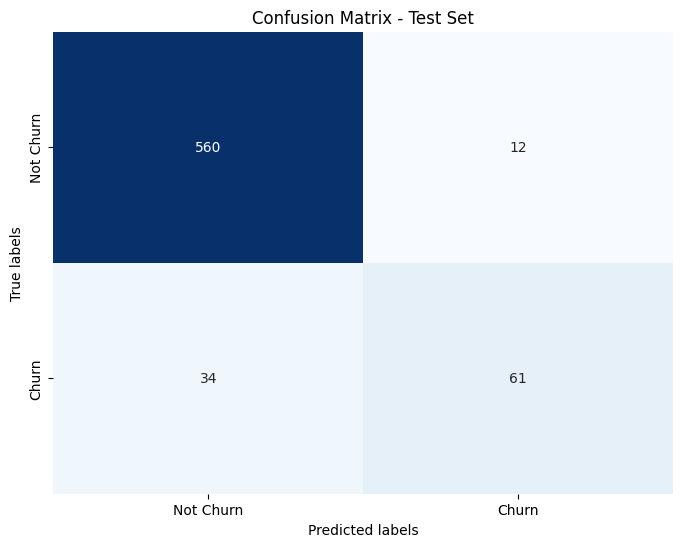

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Test Set')
plt.show()